# **KÜTÜPHANELERİ İMPORT ETME**

In [12]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

import sklearn
from sklearn.metrics import accuracy_score,cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image

import warnings # "warnings" modülü sayesinde programın çıktısındaki uyarıların konsolda görülmesini engellenir
warnings.filterwarnings("ignore")


# **GPU Kullanımını Doğrulama**

In [13]:
device = torch.device("cuda")
print("Using device: ", device)
print()

if device.type == "cuda": #cihazın bir GPU olup olmadığını kontrol eder. 
    print(torch.cuda.get_device_name(0))
    print("Memory Usage: ")
    print("Allocated: ", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Reserved: ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")


Using device:  cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage: 
Allocated:  0.0 GB
Reserved:  0.0 GB


# **Sistemin Özelliklerine Göre Otomatik Cihaz Seçimi**

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Training on GPU...Ready for HyperJumo...")
else:
    device=torch.device("cpu")
    print("Training on CPU...May the force be with you...")


Training on GPU...Ready for HyperJumo...



    Training on GPU...Ready for HyperJumo...
    Bu durumda, PyTorch modeli GPU üzerinde çalışacak ve işlemler çok daha hızlı gerçekleşecektir

CPU ise genellikle GPU'dan daha yavaş olduğu için, eğitim süreleri uzayabilir.

In [15]:
torch.cuda.is_available()

True

Eğer GPU Mevcut ve Kullanılabiliyorsa:

Sistemde bir NVIDIA GPU varsa,

CUDA sürücüleri doğru yüklenmişse,

PyTorch, CUDA'yı tanıyabiliyorsa,

Fonksiyon True döner.

**Bu işlemler, derin öğrenme ve makine öğrenimi modellerini GPU (Grafik İşlemci Birimi) üzerinde çalıştırmak için yapılır. GPU'lar, paralel işlem gücü sayesinde büyük miktarda veriyi hızlıca işleyebilir ve modellerin eğitim süresini önemli ölçüde kısaltır. İşlemlerin genel amacı, mevcut donanımı en verimli şekilde kullanarak performansı optimize etmektir.**

# **VERİ YÜKLEME**

In [16]:
# 1. Veri Yükleme
transform = transforms.Compose([
    transforms.ToTensor(), #Görüntüleri PyTorch'un anlayabileceği bir tensöre dönüştürür.
    transforms.Normalize((0.5,), (0.5,))  # Veriyi normalize et (-1, 1 aralığına getirir)
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#DataLoader: Veri setlerini eğitim veya test sırasında model için kolayca kullanılabilir hale getiren bir PyTorch sınıfıdır.

Parametreler:
root='./data': Veri setinin indirileceği/kaydedileceği klasör.

train=True: Eğitim verilerini yükler.

train=False: Test verilerini yükler.

transform=transform: Yukarıda tanımlanan dönüşümleri (ToTensor ve Normalize) veri setine uygular.

download=True: Veri seti root dizininde yoksa internetten indirir.

# *VERİ BOYUTU*

In [17]:
# Veriyi ve etiketleri elde etmek
X_train, y_train = next(iter(train_loader))  # Bir batch al
X_test, y_test = next(iter(test_loader))    # Bir batch al

# Şekilleri yazdırma
print("X_train boyutu:", X_train.shape)  # (batch_size, num_channels, height, width)
print("y_train boyutu:", y_train.shape)  # (batch_size,)
print("X_test boyutu:", X_test.shape)    # (batch_size, num_channels, height, width)
print("y_test boyutu:", y_test.shape)    # (batch_size,)



X_train boyutu: torch.Size([64, 1, 28, 28])
y_train boyutu: torch.Size([64])
X_test boyutu: torch.Size([64, 1, 28, 28])
y_test boyutu: torch.Size([64])


# **VERİ SETİNDEN RESİMLER**

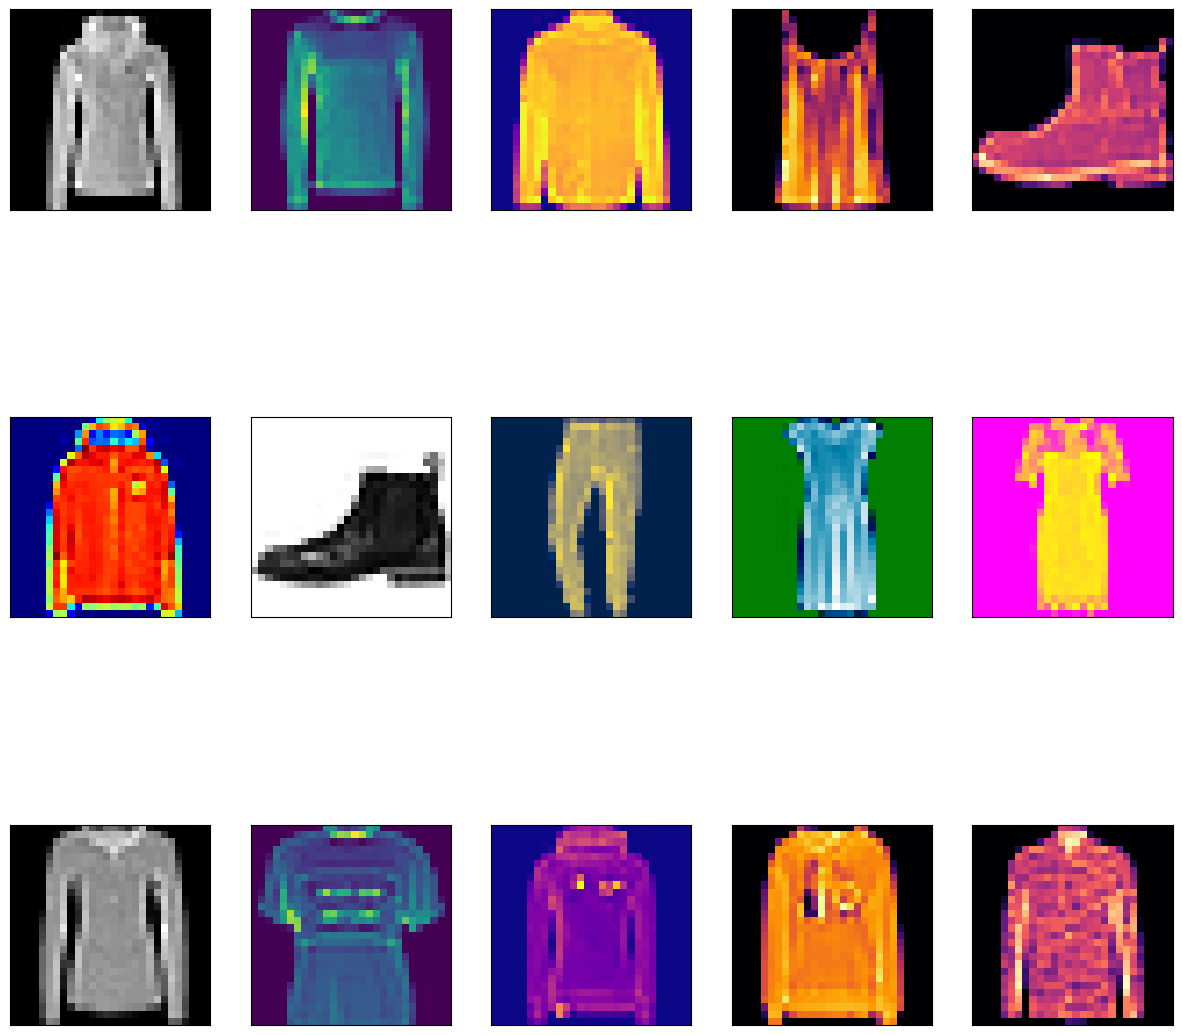

In [18]:
plt.figure(figsize=(15,15))
color_maps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'jet', 'binary', 'cividis', 'ocean', 'spring']

for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    cmap_choice = color_maps[i % len(color_maps)]  # Renk haritasından sırayla renkleri seçtirdik.
    plt.imshow(X_train[i][0], cmap=cmap_choice)
plt.show()

# **MODEL EĞİTİMİ**

*Popüler CNN modelleri*

*ResNet (Residual Networks)*

In [19]:
"""
import torchvision.models as models

# Önceden eğitilmiş ResNet modeli
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Çıkış katmanını özelleştir
"""

'\nimport torchvision.models as models\n\n# Önceden eğitilmiş ResNet modeli\nmodel = models.resnet18(pretrained=True)\nmodel.fc = nn.Linear(model.fc.in_features, 10)  # Çıkış katmanını özelleştir\n'

*Generative Models*

*GAN*

In [20]:
"""
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.net(x)
"""

'\nclass Generator(nn.Module):\n    def __init__(self, input_dim, output_dim):\n        super(Generator, self).__init__()\n        self.net = nn.Sequential(\n            nn.Linear(input_dim, 128),\n            nn.ReLU(),\n            nn.Linear(128, output_dim),\n            nn.Tanh()\n        )\n    \n    def forward(self, x):\n        return self.net(x)\n'

*Fully Connected Neural Network(FCNN)*

In [21]:

# Model Tanımlama
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FashionMNISTModel()


In [22]:

# Kayıp Fonksiyonu ve Optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Model Eğitimi
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.5124
Epoch 2/10, Loss: 0.3761
Epoch 3/10, Loss: 0.3342
Epoch 4/10, Loss: 0.3142
Epoch 5/10, Loss: 0.2960
Epoch 6/10, Loss: 0.2785
Epoch 7/10, Loss: 0.2679
Epoch 8/10, Loss: 0.2555
Epoch 9/10, Loss: 0.2436
Epoch 10/10, Loss: 0.2346


*MODEL TESTİ VE GÖRÜNTÜLEME*

Test Accuracy: 88.11%


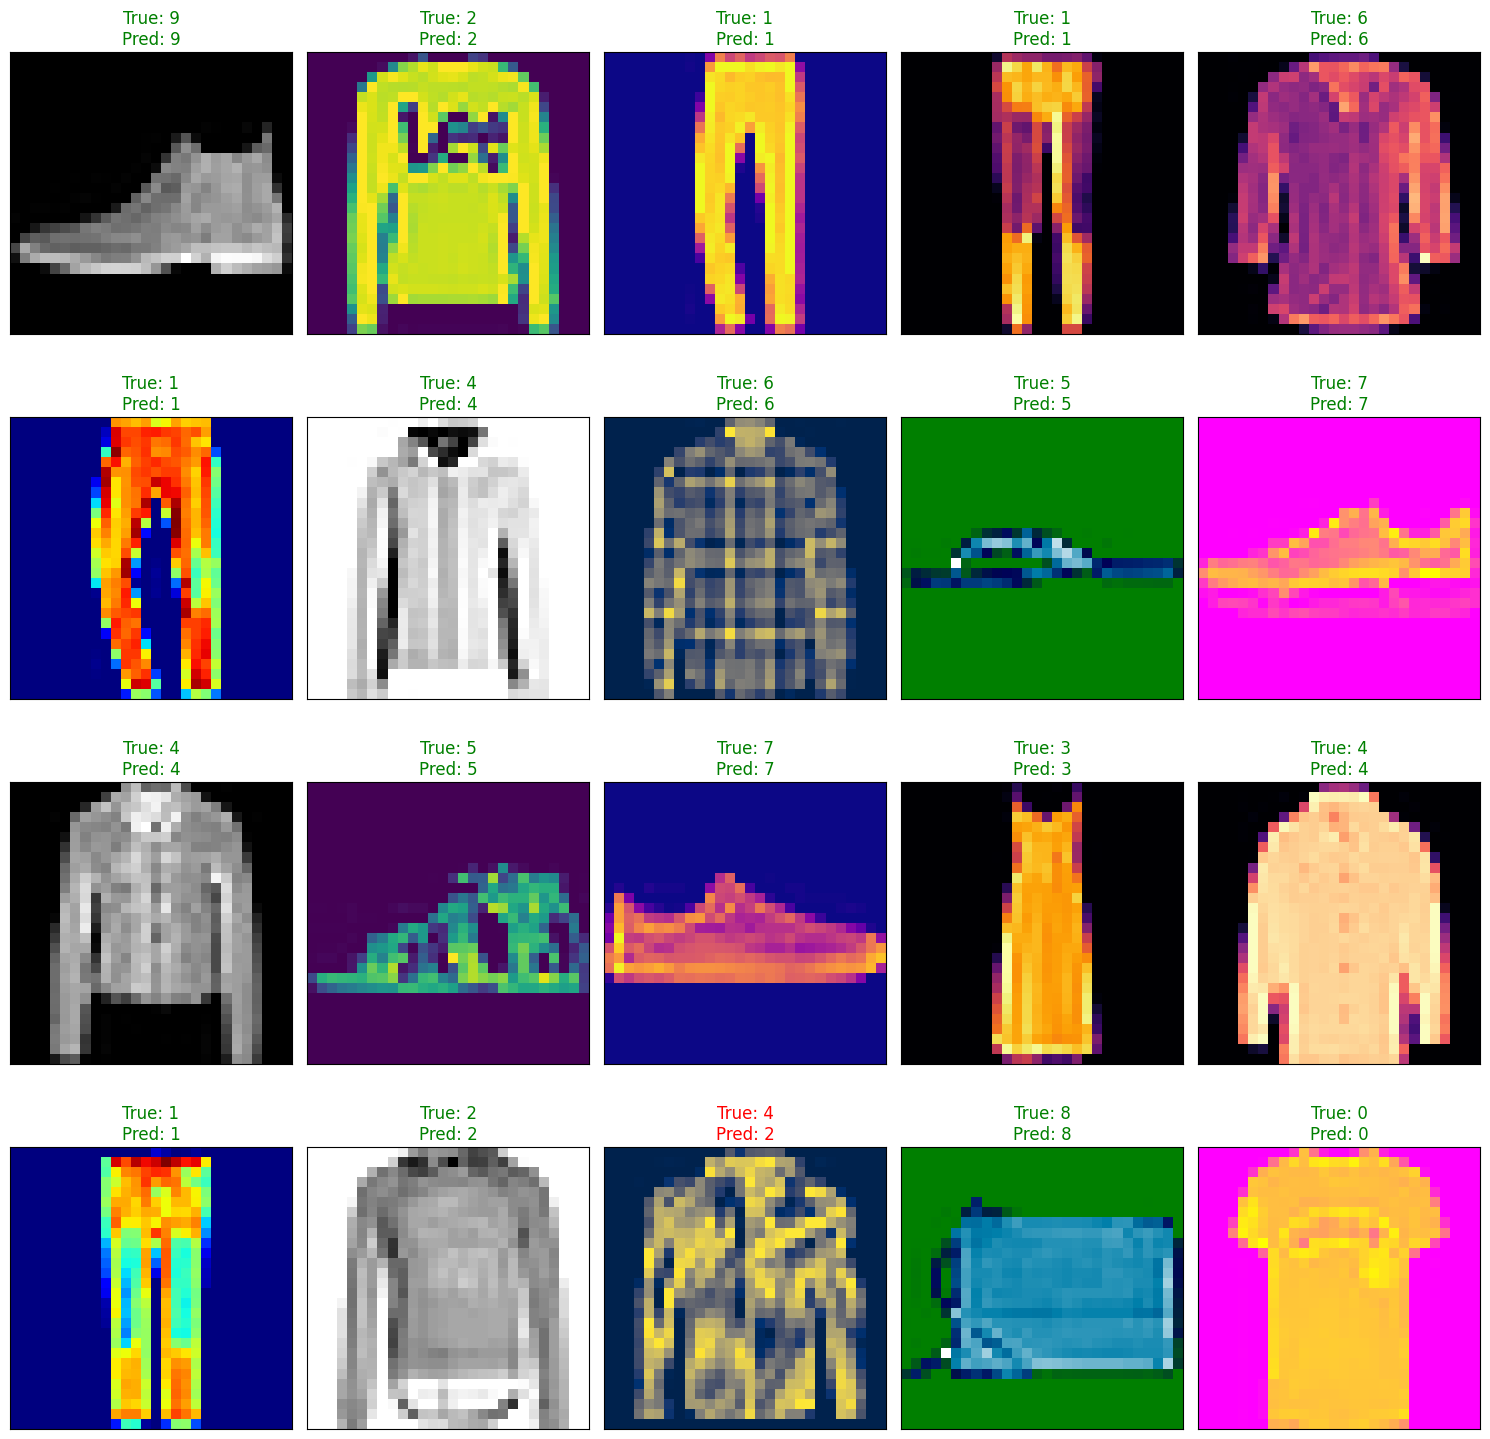

In [24]:
# Model Testi
model.eval()
correct = 0
total = 0
all_images = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Görselleştirme için görüntüleri, etiketleri ve tahminleri toplama
        all_images.extend(images)
        all_labels.extend(labels)
        all_predictions.extend(predicted)

# Test Doğruluğunu Yazzdırma
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Görselleştirme
plt.figure(figsize=(15, 15))
color_maps = ['gray', 'viridis', 'plasma', 'inferno', 'magma', 'jet', 'binary', 'cividis', 'ocean', 'spring']

for i in range(20):  # 20 resim göster
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = all_images[i].squeeze().numpy()  # Kanalı kaldırın ve numpy'ye dönüştür
    true_label = all_labels[i].item()
    pred_label = all_predictions[i].item()
    cmap_choice = color_maps[i % len(color_maps)]  # Renk haritasından sırayla renkleri seçtirdik.
    plt.imshow(image, cmap=cmap_choice)  # Resmi göster
    plt.title(f"True: {true_label}\nPred: {pred_label}", 
              color="green" if true_label == pred_label else "red")

plt.tight_layout()


*%88.71 doğruluk, bu model türü için beklenen düzeyde iyi bir sonuçtur. Ancak, CNN gibi daha ileri model mimarileri ve veri artırma teknikleri ile bu doğruluğu %93 veya daha üst seviyelere çıkarabiliriz*